In [53]:

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA
from utils.model_operations import *
from utils.image_operations import *
import matplotlib.pyplot as plt


directory_path = os.getcwd()

def loadModelWeights():
    """
    returns dataframe with the weights of all models by layers
    """
    bias = ['0.02', '0.03', '0.04', '0.05']
    df = pd.DataFrame()
    modelId = 0
    for b in bias:
        model_data = ModelDataset(bias=b, data_directory=directory_path+'/data/DigitWdb/train')
        temp = []
        for modelNumber in tqdm(range(len(model_data)//1), desc="loading model weights with bias "+b):
            model = model_data[modelNumber].get_weights()
            for layer in range(0,len(model)):
                df = df.append({'modelId':modelId,'weights':np.ravel(model[layer]),'layer':layer, 'bias':b}, ignore_index=True)
            modelId += 1       
    return df
            
modelWeights = loadModelWeights()
modelWeights

loading model weights with bias 0.05: 100%|██████████| 2000/2000 [05:44<00:00,  5.80it/s]


,bias,layer,modelId,weights
0,0.02,0.0,0.0,"[-0.018486138, -0.03354981, -0.16535422, -0.06..."
1,0.02,1.0,0.0,"[-0.24564764, -0.081536554, -0.01958792, -0.11..."
2,0.02,2.0,0.0,"[-0.26035, -0.031969644, 0.02034611, 0.0241116..."
3,0.02,3.0,0.0,"[-0.08751261, 0.14474091, -0.26124775, -0.2221..."
4,0.02,4.0,0.0,"[-0.045246184, -0.022445709, -0.17450637, -0.0..."
...,...,...,...,...
79995,0.05,5.0,7999.0,"[0.010443132, -0.18427786, -0.066259846, -0.03..."
79996,0.05,6.0,7999.0,"[-2.1241395, 0.58485734, -2.2942114, 0.4497387..."
79997,0.05,7.0,7999.0,"[3.359927, 1.6769673, 2.8587103, 2.1773515, 2...."
79998,0.05,8.0,7999.0,"[-0.038149532, -0.024797479, 0.02632919, 0.175..."


,score
layer,
0.0,0.002348
1.0,0.081329
2.0,-0.000732
3.0,0.149428
4.0,0.220155
5.0,0.000465
6.0,0.993166
7.0,0.996721
8.0,0.998343


<AxesSubplot:title={'center':'score of baseline per layer'}, xlabel='layer', ylabel='score'>

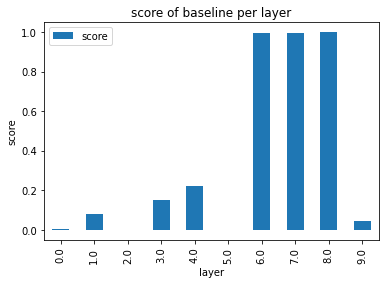

In [132]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import adjusted_rand_score

modelWeightsCopy = modelWeights.copy()

results = pd.DataFrame(columns=['layer','score'])

for layer in range(0,10):
    temp = modelWeightsCopy[modelWeightsCopy['layer'] == layer]


    # extract weights and bias
    X = [x[0] for x in temp[['weights']].values]
    y = temp['bias']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


    # reduce first with a simple PCA
    pca = PCA(n_components=10)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)


    # use KNN as baseline
    neigh = KNeighborsClassifier(n_neighbors=10)
    neigh.fit(X_train, y_train)

    # predict and evaluate our predictions, bad labeling is 0 or negative, best is 1
    predictions = neigh.predict(X_test)

    results = results.append({'layer':layer,'score':adjusted_rand_score(predictions,y_test)}, ignore_index=True)
    #print("baseline score in layer",layer,":",adjusted_rand_score(predictions,y_test))
results = results.set_index('layer')
display(results)
fig = results.plot(kind='bar', xlabel='layer', ylabel='score', title='score of baseline per layer')
fig.get_figure().savefig('baseline.jpg')
display(fig)